In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Question 3


## part a

<h3> in this section we want to implement histogram equalization </h3>
<h3> you can use opencv library </h3>

In [2]:
image = cv2.imread('img_improvment.png',cv2.IMREAD_GRAYSCALE)
output_image = image.copy()
equalize_image = cv2.equalizeHist(image) ## your code here ##

(-0.5, 383.5, 287.5, -0.5)

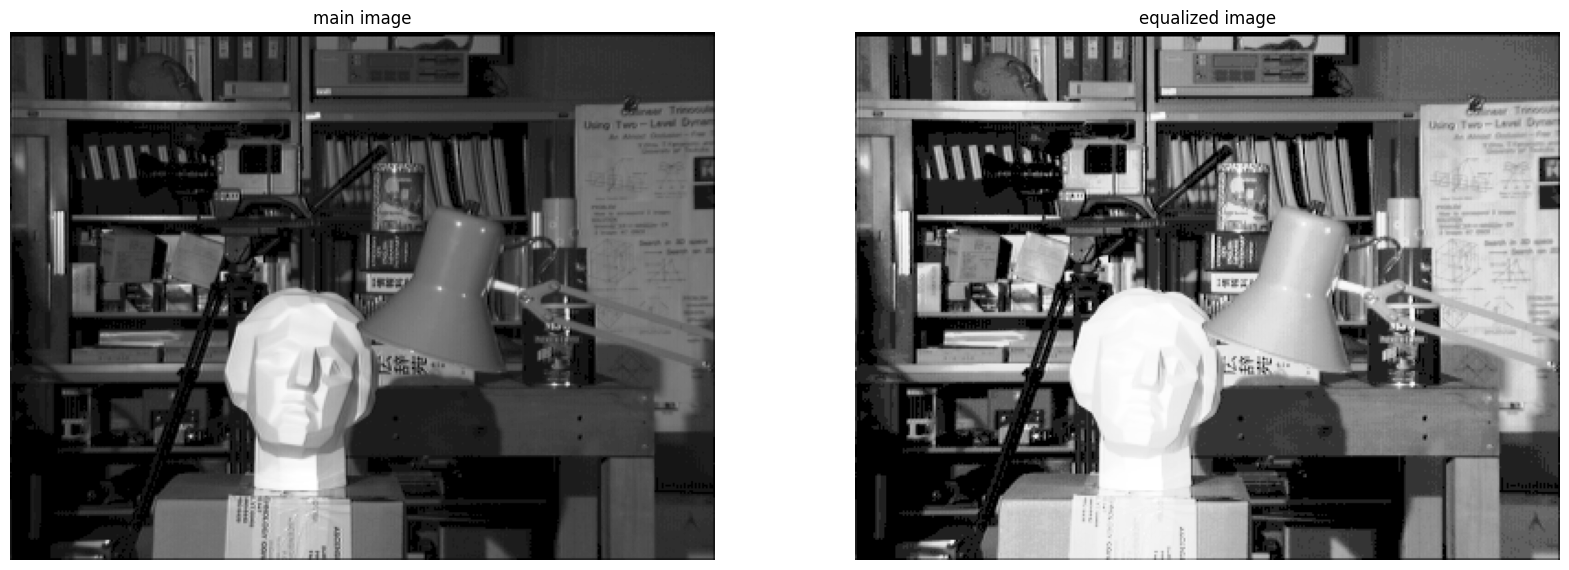

In [3]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('main image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(equalize_image, cmap='gray')
plt.title('equalized image')
plt.axis('off')

## part b1


<h3> in this section we want to implement the first method for ACE </h3>
<h3> you are free to use opencv library </h3>


In [4]:
def ACE1(image, gridSize):
  '''
  you can use the equalize function of OpenCV for each grid
  Use first method for ACE implementation (calculating transition function for each grid)
  input(s):
    image (ndarray): input image
    gridSize (int): window size for calculating histogram equalization
  output(s):
    output (ndarray): improved image
  '''
  x,y = image.shape
  output_image = image.copy()

  #######################
  #    your code here   #
  #######################

  # Iterate over the image with the specified grid size
  for i in range(0, x, gridSize):
      for j in range(0, y, gridSize):
          # Define the region (grid) to apply histogram equalization
          grid = output_image[i:min(i + gridSize, x), j:min(j + gridSize, y)]

          # Apply histogram equalization to the grid
          equalized_grid = cv2.equalizeHist(grid)

          # Place the equalized grid back into the output image
          output_image[i:min(i + gridSize, x), j:min(j + gridSize, y)] = equalized_grid

  return output_image

(-0.5, 383.5, 287.5, -0.5)

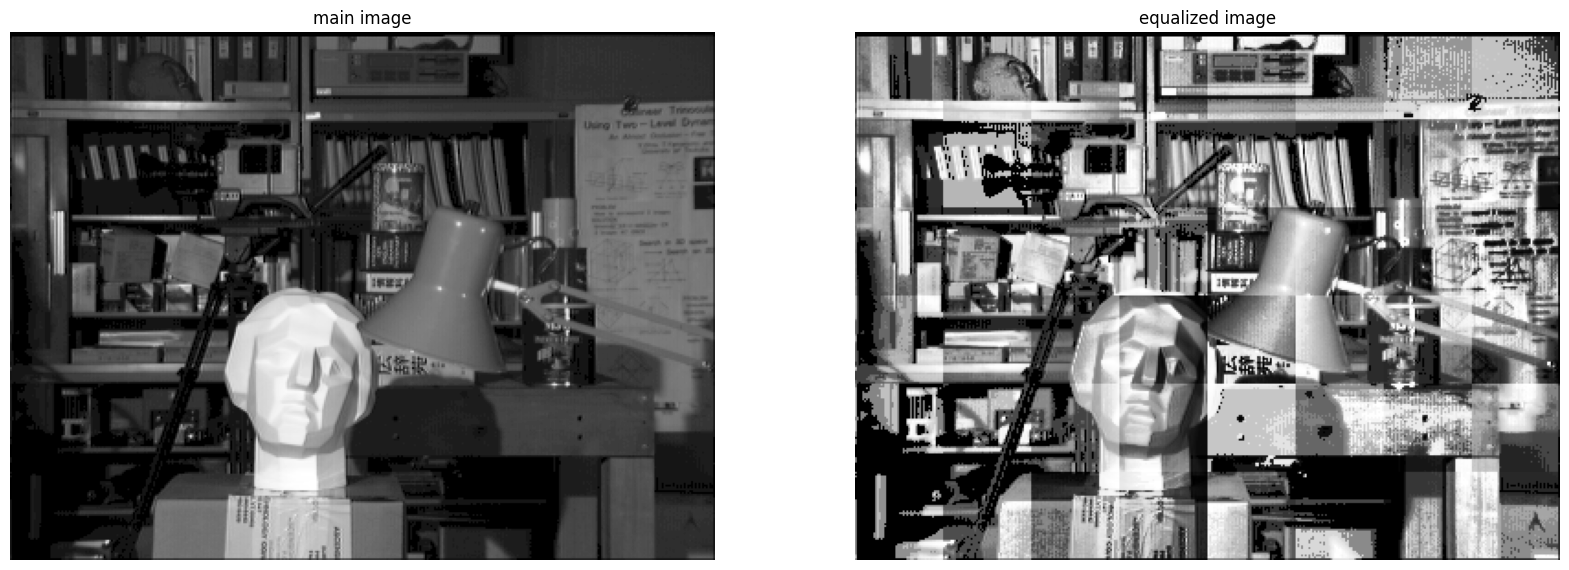

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('main image')
plt.axis('off')

plt.subplot(1,2,2)
output_image = ACE1(image,48)
plt.imshow(output_image, cmap='gray')
plt.title('equalized image')
plt.axis('off')

## part b2

<h3> in this section we want to implement the second method for ACE </h3>
<h3> you are free to use opencv library </h3>

In [ ]:
def ACE2(image, gridSize):
    '''
    you can just use the equalize function of OpenCV for each grid
    You can use OpenCV built-in tools for applying padding
    Use second method for ACE implementation (calculating transition function for each pixel)
    input(s):
      image (ndarray): input image
      gridSize (tuple): window size for calculating histogram equalization
    output(s):
      output (ndarray): improved image
    '''
    output = image.copy()

    #######################
    #    your code here   #
    #######################
    # Get image dimensions
    x, y = image.shape

    # Compute half the grid size for easier navigation
    half_grid = gridSize // 2

    # Pad the image using reflect101 padding
    padded_image = cv2.copyMakeBorder(output, half_grid, half_grid, half_grid, half_grid,
                                      cv2.BORDER_REFLECT_101)

    # Iterate through each pixel in the output image
    for i in range(half_grid, x + half_grid):
        for j in range(half_grid, y + half_grid):
            # Extract the local region around the current pixel
            local_region = padded_image[i - half_grid:i + half_grid + 1, j - half_grid:j + half_grid + 1]

            # Apply histogram equalization to this local region
            local_eq = cv2.equalizeHist(local_region)

            # Set the pixel in the output image to the center pixel in the equalized local region
            output[i - half_grid, j - half_grid] = local_eq[half_grid, half_grid]
    return output

(-0.5, 383.5, 287.5, -0.5)

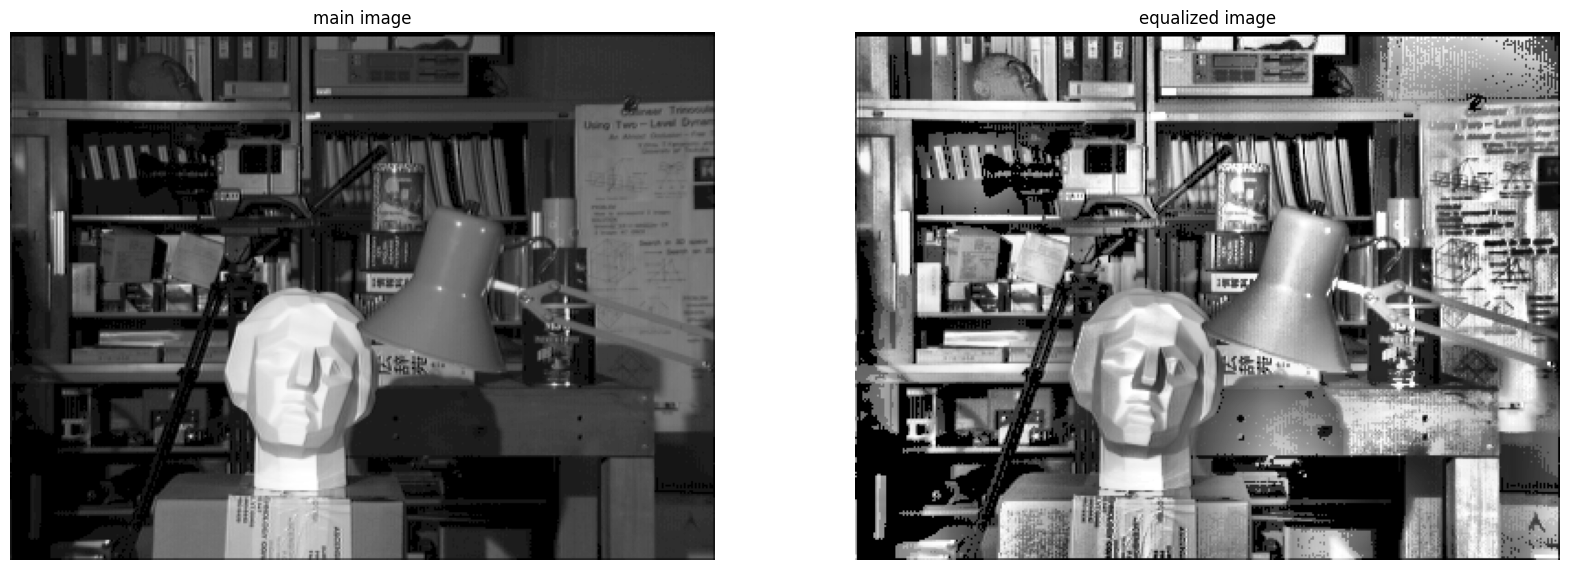

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('main image')
plt.axis('off')

plt.subplot(1,2,2)
output_image = ACE2(image,70)
plt.imshow(output_image, cmap='gray')
plt.title('equalized image')
plt.axis('off')

## part b3

<h3> in this section we want to implement CLAHE </h3>
<h3><b> note : you can just use opencv library for calculate histogram and applying padding </b></h3>
<h3><b>note : you can't use the equalize function of opencv</b></h3>

In [ ]:
def clip_histogram(histogram, clip_limit):
    excess_count = sum(histogram) - clip_limit
    bins = histogram.shape[0]

    # Clip the histogram and redistribute excess pixels
    average_increment = excess_count // bins
    excess_count -= average_increment * bins
    clipped_histogram = histogram + average_increment

    # Further redistribute remaining excess pixels
    for i in range(bins):
        if excess_count <= 0:
            break
        if clipped_histogram[i] < clip_limit:
            clipped_histogram[i] += 1
            excess_count -= 1

    return clipped_histogram

def calculate_cdf(histogram):
    # Calculate the normalized cumulative distribution function from a histogram
    cdf = histogram.cumsum()
    cdf = np.ma.masked_equal(cdf, 0)
    cdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    cdf = np.ma.filled(cdf, 0).astype('uint8')

    return cdf

def CLAHE(image, gridSize, clip_limit):
    '''
    you can just use opencv library for calculate histogram and applying padding
    you can't use the equalize function of opencv
    Use second method for ACE implementation (calculating transition function for each pixel)
    input(s):
      image (ndarray): input image
      gridSize (tuple): window size for calculating histogram equalization
      clip_limit (int): threshold for contrast limiting
    output(s):
      output (ndarray): improved image
    '''
    output = image.copy()

    #######################
    #    your code here   #
    #######################

    x, y = image.shape

    # Define the effective clip limit for each grid
    clip_limit_effective = clip_limit * (gridSize[0] * gridSize[1]) / 256
    clip_limit_effective = max(clip_limit_effective, 1)

    padded_image = cv2.copyMakeBorder(output, gridSize[0]//2, gridSize[0]//2, gridSize[1]//2, gridSize[1]//2, cv2.BORDER_REFLECT_101)

    for i in range(0, x, gridSize[0]):
        for j in range(0, y, gridSize[1]):
            region_x_end = min(i + gridSize[0], x)
            region_y_end = min(j + gridSize[1], y)

            region = padded_image[i:i + gridSize[0], j:j + gridSize[1]]
            histogram, _ = np.histogram(region.flatten(), bins=256, range=[0, 256])

            clipped_histogram = clip_histogram(histogram, clip_limit_effective)
            cdf = calculate_cdf(clipped_histogram)

            # Map the pixel values
            region_equalized = cdf[region.flatten()].reshape(region.shape)
            output[i:region_x_end, j:region_y_end] = region_equalized[0:(region_x_end - i), 0:(region_y_end - j)]

    return output

(-0.5, 383.5, 287.5, -0.5)

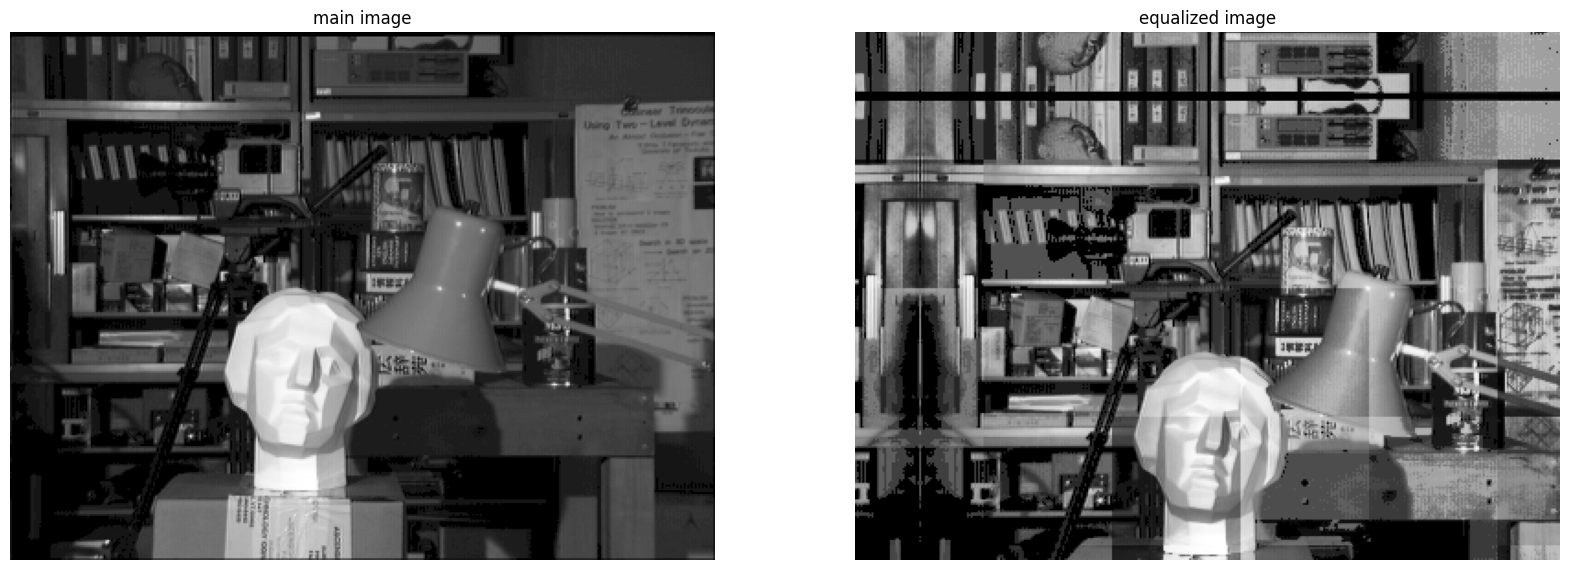

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('main image')
plt.axis('off')

plt.subplot(1,2,2)
output_image = CLAHE(image,(70,70), 100)
plt.imshow(output_image, cmap='gray')
plt.title('equalized image')
plt.axis('off')

# part c


<h3> in this section we want to implement CLAHE using opencv </h3>


In [ ]:
def CLAHE(image, gridSize, clipLimit):
    '''
    use opencv library for CLAHE.
    input(s):
      image (ndarray): input image
      gridSize (tuple): window size for calculating histogram equalization
      clip_limit (int): threshold for contrast limiting
    output(s):
      output (ndarray): improved image
    '''
    # Create a CLAHE object with specified gridSize and clipLimit
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=gridSize)

    # Apply CLAHE to the input image
    clahe_output = clahe.apply(image)

    return clahe_output

<h3> run the following sections to answer part c </h3>


(-0.5, 383.5, 287.5, -0.5)

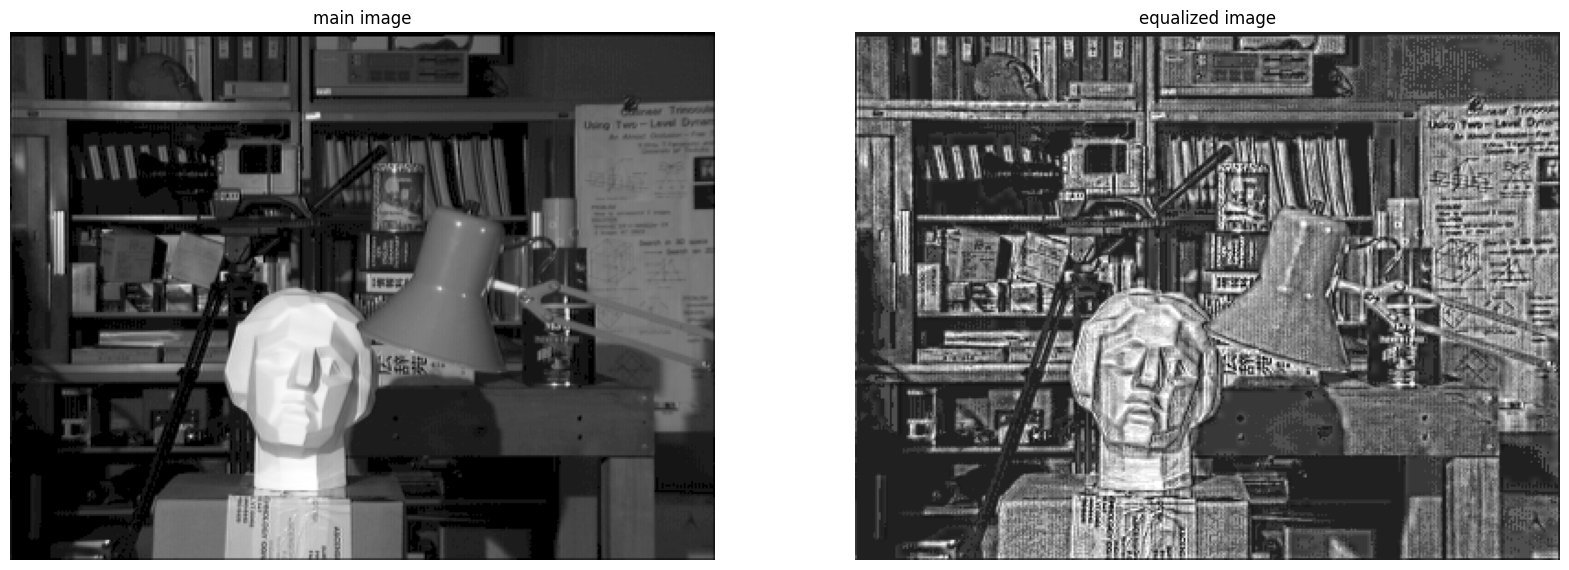

In [ ]:
# dont change this cell
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('main image')
plt.axis('off')

plt.subplot(1,2,2)
output_image1 = CLAHE(image,(128,128), 2)
plt.imshow(output_image1, cmap='gray')
plt.title('equalized image')
plt.axis('off')

(-0.5, 383.5, 287.5, -0.5)

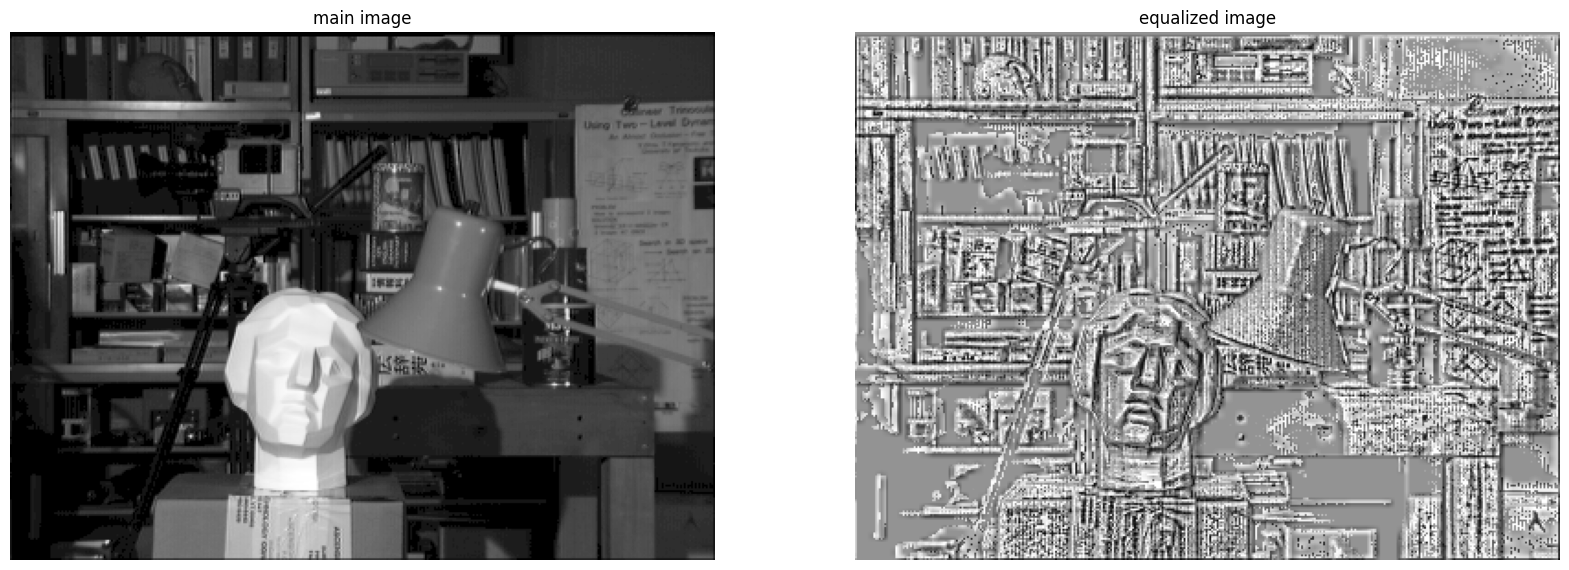

In [ ]:
# dont change this cell
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('main image')
plt.axis('off')

plt.subplot(1,2,2)
output_image2 = CLAHE(image,(128,128), 128)
plt.imshow(output_image2, cmap='gray')
plt.title('equalized image')
plt.axis('off')

(-0.5, 383.5, 287.5, -0.5)

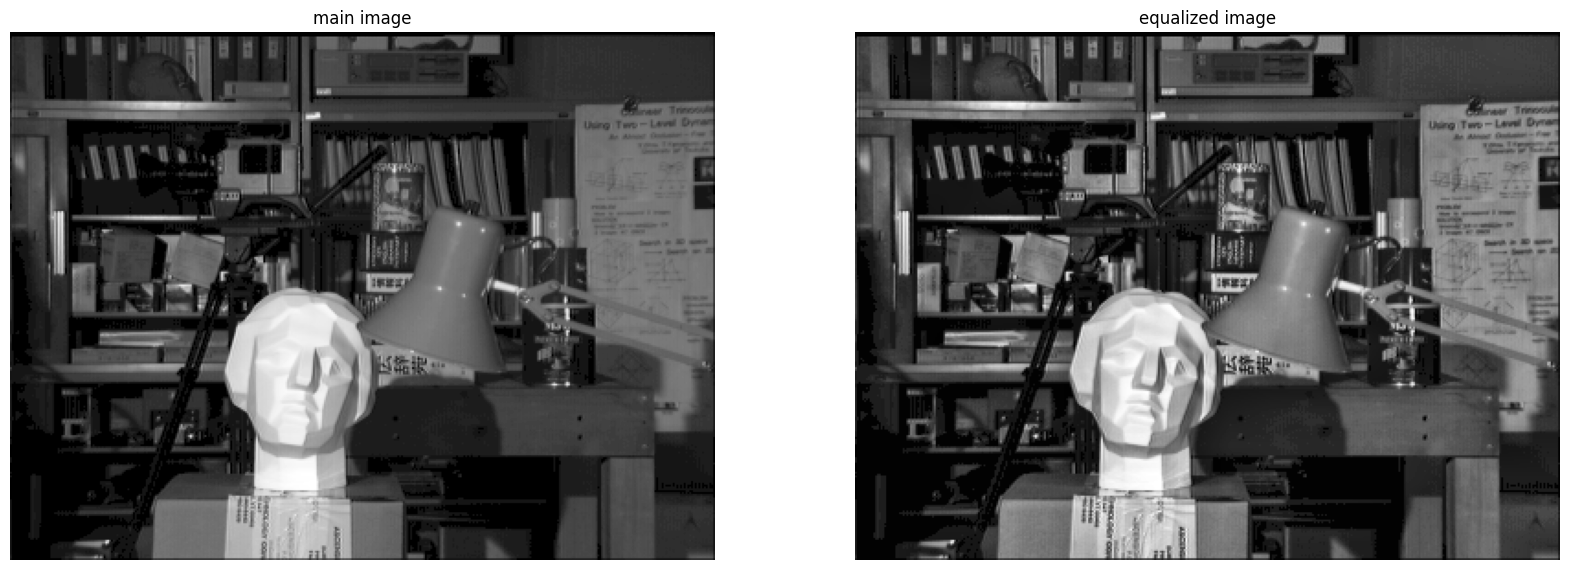

In [ ]:
# dont change this cell
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('main image')
plt.axis('off')

plt.subplot(1,2,2)
output_image3 = CLAHE(image,(16,16), 2)
plt.imshow(output_image3, cmap='gray')
plt.title('equalized image')
plt.axis('off')

(-0.5, 383.5, 287.5, -0.5)

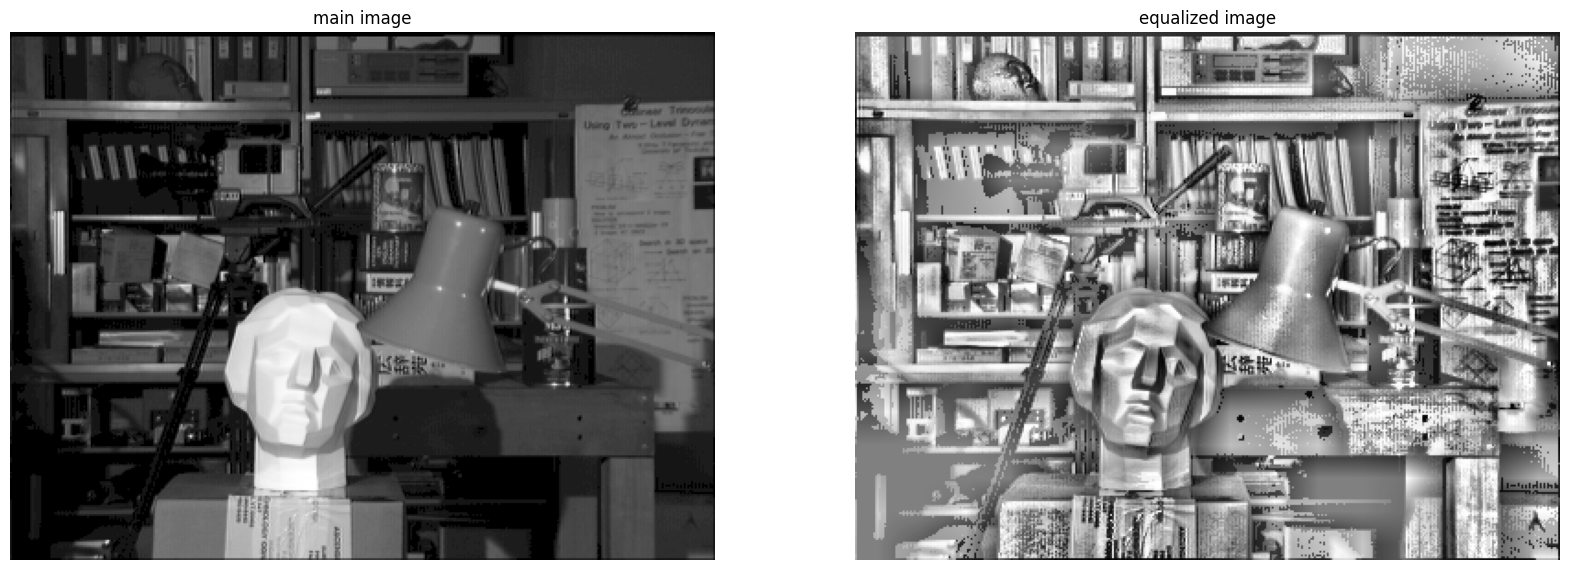

In [ ]:
# dont change this cell
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('main image')
plt.axis('off')

plt.subplot(1,2,2)
output_image4 = CLAHE(image,(16,16), 128)
plt.imshow(output_image4, cmap='gray')
plt.title('equalized image')
plt.axis('off')